# Applied Data Science Capstone Project: Total population and the most popular venues in Zurich city, Switzerland #

In this project we will analyse the most popular venues in the neighborhoods of Zurich city, Switzerland. The final goal is to generate a map and a summary table showing the total population and the most abundant venues in each neighborhood. 

The purpose of this project is to explore the current situation in the city and to observe the general trends, for example: Which are globally the most popular venues in the city? Are the most popular venues the same in each neighborhood? Are there differences between more and less populated neighborhoods? 

## Part 1: Preparing the dataframe and the .json file and installing some of the necessary packages for the analysis ##

### Installing the packages to create the dataframe ###

In [1]:
import pandas as pd
import numpy as np

### Creating a dataframe from a csv file uploaded from my computer ###

In [2]:
data_zurich = pd.read_csv('zurich_geo.csv')
data_zurich.head()

,Borough,Neighborhood,Latitude,Longitude,Population (2018),Population density / km²
0,Kreis 1 – Altstadt,Rathaus,47.37161,8.54501,3267,3194
1,Kreis 1 – Altstadt,Hochschulen,47.36601,8.54594,664,3194
2,Kreis 1 – Altstadt,Lindenhof,47.37188,8.54036,990,3194
3,Kreis 1 – Altstadt,City,47.37269,8.53576,829,3194
4,Kreis 2,Wollishofen,47.34010,8.53134,18923,3151


In [3]:
data_zurich.shape

(34, 6)

### Installing the additionnal packages for the map creation ###

In [4]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    lib

### Importing the .json file uploaded from my computer ###

In [5]:
geo_zurich = r'adm_statistische_quartiere_map.json'

## Part 2: Creating choropleth maps of Zurich showing the total population and the population density / km² in every neighborhood ## 

### Creating a map centered on Zurich ###

In [6]:
# Defining an instance of the geocoder
address = 'Zurich'

geolocator = Nominatim(user_agent="zurich_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Zurich are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Zurich are 47.3723941, 8.5423328.


In [9]:
# Creating a map centered on Zurich
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=11)

### Creating a choropleth map of the population density / km² in every neighborhood in Zurich city ###

In [10]:
# generate choropleth map using the population density in every neighborhood in Zurich city
map_zurich.choropleth(
    geo_data=geo_zurich,
    data=data_zurich,
    columns=['Neighborhood', 'Population density / km²'],
    key_on='feature.properties.qname',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population density / km² in every neighborhood in Zurich city'
)

# display map
map_zurich

In case the map doesn't show, here is a screenshot of the map
![](pop_dens.png)

### Creating a choropleth map of the total population in every neighborhood in Zurich city ###

In [8]:
# generate choropleth map using the total population in every neighborhood in Zurich city
map_zurich.choropleth(
    geo_data=geo_zurich,
    data=data_zurich,
    columns=['Neighborhood', 'Population (2018)'],
    key_on='feature.properties.qname',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Total population in every neighborhood in Zurich city (2018)'
)

# display map
map_zurich

In case the map doesn't show, here is a screenshot of the map
![](tot_pop.png)

## Part 3: Exploring the venues in the neighborhoods of Zurich city with Foursquare API ##

### Defining Foursquare Credentials and Version ###

In [11]:
CLIENT_ID = '55MPXSTGUABHT31JTO4LNQH44YXH0NGZTMIV05NJ1KKESMS3' # my Foursquare ID
CLIENT_SECRET = 'B1L0E1CPY1FIXPO1YXEAM5AC5MYHNNM1D1GXQVINITQOVNGJ' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 55MPXSTGUABHT31JTO4LNQH44YXH0NGZTMIV05NJ1KKESMS3
CLIENT_SECRET:B1L0E1CPY1FIXPO1YXEAM5AC5MYHNNM1D1GXQVINITQOVNGJ


### Exploring neighborhoods in Zurich city ###

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
zurich_venues = getNearbyVenues(names=data_zurich['Neighborhood'],
                                   latitudes=data_zurich['Latitude'],
                                   longitudes=data_zurich['Longitude']
                                  )

Rathaus
Hochschulen
Lindenhof
City
Wollishofen
Leimbach
Enge
Alt-Wiedikon
Friesenberg
Sihlfeld
Werd
Langstrasse
Hard
Gewerbeschule
Escher Wyss
Unterstrass
Oberstrass
Fluntern
Hottingen
Hirslanden
Witikon
Seefeld
Mühlebach
Weinegg
Albisrieden
Altstetten
Höngg
Wipkingen
Affoltern
Oerlikon
Seebach
Saatlen
Schwamendingen-Mitte
Hirzenbach


In [15]:
print(zurich_venues.shape)
zurich_venues.head()

(1121, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rathaus,47.37161,8.54501,Fitnesspark Münstergasse,47.370888,8.544999,Gym / Fitness Center
1,Rathaus,47.37161,8.54501,Café Schober,47.371400,8.544149,Café
2,Rathaus,47.37161,8.54501,Schwarzenbach Kolonialwaren,47.371444,8.544091,Gourmet Shop
3,Rathaus,47.37161,8.54501,Äss-Bar,47.372561,8.543693,Bakery
4,Rathaus,47.37161,8.54501,Neumarkt 17 AG,47.372868,8.546121,Furniture / Home Store


In [16]:
zurich_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Affoltern,13,13,13,13,13,13
Albisrieden,10,10,10,10,10,10
Alt-Wiedikon,21,21,21,21,21,21
Altstetten,39,39,39,39,39,39
City,100,100,100,100,100,100
Enge,36,36,36,36,36,36
Escher Wyss,51,51,51,51,51,51
Fluntern,14,14,14,14,14,14
Friesenberg,5,5,5,5,5,5


In [17]:
print('There are {} uniques categories.'.format(len(zurich_venues['Venue Category'].unique())))

There are 190 uniques categories.


### Analyzing each neighborhood ###

In [18]:
# one hot encoding
zurich_onehot = pd.get_dummies(zurich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
zurich_onehot['Neighborhood'] = zurich_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [zurich_onehot.columns[-1]] + list(zurich_onehot.columns[:-1])
zurich_onehot = zurich_onehot[fixed_columns]

zurich_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Rathaus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rathaus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rathaus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rathaus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rathaus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
zurich_onehot.shape

(1121, 191)

Grouping rows by neighborhood and by taking the mean of the frequency of occurence of each category

In [20]:
zurich_grouped = zurich_onehot.groupby('Neighborhood').mean().reset_index()
zurich_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Affoltern,0.0,0.0,0.00,0.0,0.00,0.00,0.000000,0.076923,0.0,...,0.000000,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0
1,Albisrieden,0.0,0.0,0.00,0.0,0.00,0.00,0.000000,0.000000,0.0,...,0.100000,0.1,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0
2,Alt-Wiedikon,0.0,0.0,0.00,0.0,0.00,0.00,0.047619,0.000000,0.0,...,0.000000,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0
3,Altstetten,0.0,0.0,0.00,0.0,0.00,0.00,0.025641,0.000000,0.0,...,0.076923,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0
4,City,0.0,0.0,0.01,0.0,0.01,0.01,0.010000,0.000000,0.0,...,0.010000,0.0,0.04,0.01,0.0,0.0,0.01,0.01,0.01,0.0


In [21]:
zurich_grouped.shape

(34, 191)

Printing each neighborhood along with the top 5 most common venues

In [22]:
num_top_venues = 5

for hood in zurich_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = zurich_grouped[zurich_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Affoltern----
                venue  freq
0         Bus Station  0.23
1         Supermarket  0.15
2  Miscellaneous Shop  0.08
3  Athletics & Sports  0.08
4  Light Rail Station  0.08


----Albisrieden----
               venue  freq
0        Bus Station   0.3
1        Supermarket   0.2
2        Pizza Place   0.1
3  Trattoria/Osteria   0.1
4   Swiss Restaurant   0.1


----Alt-Wiedikon----
                 venue  freq
0   Italian Restaurant  0.14
1           Restaurant  0.10
2          Supermarket  0.10
3          Beer Garden  0.05
4  Japanese Restaurant  0.05


----Altstetten----
              venue  freq
0       Supermarket  0.13
1      Tram Station  0.08
2             Hotel  0.05
3      Burger Joint  0.05
4  Swiss Restaurant  0.05


----City----
          venue  freq
0           Bar  0.07
1    Restaurant  0.06
2         Hotel  0.06
3  Cocktail Bar  0.05
4          Café  0.05


----Enge----
                venue  freq
0                 Bar  0.11
1                Park  0.11
2  Italian

### Putting the information about the venues into a pandas dataframe ###

Defining a function to sort the venues in descending order:

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the new dataframe and displaying the top 10 venues for each neighborhood:

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = zurich_grouped['Neighborhood']

for ind in np.arange(zurich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zurich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affoltern,Bus Station,Supermarket,Massage Studio,Department Store,Athletics & Sports,Light Rail Station,Train Station,Italian Restaurant,Miscellaneous Shop,Restaurant
1,Albisrieden,Bus Station,Supermarket,Pizza Place,Grocery Store,Trattoria/Osteria,Tram Station,Swiss Restaurant,Discount Store,Farmers Market,Falafel Restaurant
2,Alt-Wiedikon,Italian Restaurant,Supermarket,Restaurant,Bus Station,Sporting Goods Shop,Thai Restaurant,Bakery,Japanese Restaurant,Diner,Pizza Place
3,Altstetten,Supermarket,Tram Station,Bakery,Burger Joint,Plaza,Hotel,Swiss Restaurant,Japanese Restaurant,Café,Discount Store
4,City,Bar,Hotel,Restaurant,Cocktail Bar,Café,Swiss Restaurant,Italian Restaurant,Plaza,Department Store,Vegetarian / Vegan Restaurant


## Part 4: Clustering neighborhoods ##

Finding the optimal value for k with the elbow method

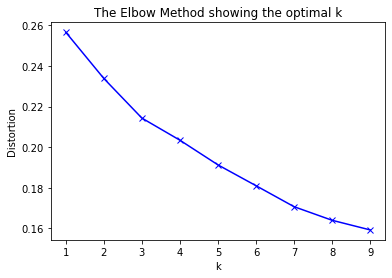

In [26]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
zurich_grouped_clustering = zurich_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(zurich_grouped_clustering)
    kmeanModel.fit(zurich_grouped_clustering)
    distortions.append(sum(np.min(cdist(zurich_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / zurich_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Running k-means to cluster the neighborhood into 6 clusters

In [28]:
# set number of clusters
kclusters = 6

zurich_grouped_clustering = zurich_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(zurich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 1, 1, 2, 2, 2, 1, 4, 2], dtype=int32)

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood:

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

zurich_merged = data_zurich

zurich_merged = zurich_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [30]:
zurich_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Population (2018),Population density / km²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kreis 1 – Altstadt,Rathaus,47.37161,8.54501,3267,3194,2,Swiss Restaurant,Bar,Café,Plaza,Cocktail Bar,Restaurant,Italian Restaurant,French Restaurant,Spanish Restaurant,Hotel
1,Kreis 1 – Altstadt,Hochschulen,47.36601,8.54594,664,3194,2,Bar,Hotel,Swiss Restaurant,Coffee Shop,French Restaurant,Café,Plaza,Supermarket,Bakery,Lounge
2,Kreis 1 – Altstadt,Lindenhof,47.37188,8.54036,990,3194,2,Café,Swiss Restaurant,Boutique,French Restaurant,Bar,Hotel,Cocktail Bar,Lounge,Restaurant,Department Store
3,Kreis 1 – Altstadt,City,47.37269,8.53576,829,3194,2,Bar,Hotel,Restaurant,Cocktail Bar,Café,Swiss Restaurant,Italian Restaurant,Plaza,Department Store,Vegetarian / Vegan Restaurant
4,Kreis 2,Wollishofen,47.34010,8.53134,18923,3151,0,Restaurant,Bus Station,Bar,Irish Pub,Supermarket,Pool,Cheese Shop,Gas Station,Thai Restaurant,Falafel Restaurant


## Part 5: Adding the clusters to the choropleth map ##

Visualizing the resulting clusters

In [31]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zurich_merged['Latitude'], zurich_merged['Longitude'], zurich_merged['Neighborhood'], zurich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_zurich)
       
map_zurich

In case the map doesn't show, here is a screenshot of the map
![](pop_dens_with_clusters.png)

## Part 6: Examining clusters ##

Here we will examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we could assign a name to each cluster.

### Cluster 1 ###

In [32]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 0, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Neighborhood,Population density / km²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Wollishofen,3151,0,Restaurant,Bus Station,Bar,Irish Pub,Supermarket,Pool,Cheese Shop,Gas Station,Thai Restaurant,Falafel Restaurant
20,Witikon,2543,0,Bus Station,Indian Restaurant,Optical Shop,Supermarket,Department Store,Tram Station,Church,Bakery,Yoga Studio,Electronics Store
28,Affoltern,5614,0,Bus Station,Supermarket,Massage Studio,Department Store,Athletics & Sports,Light Rail Station,Train Station,Italian Restaurant,Miscellaneous Shop,Restaurant


### Cluster 2 ###

In [33]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 1, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Neighborhood,Population density / km²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Alt-Wiedikon,5846,1,Italian Restaurant,Supermarket,Restaurant,Bus Station,Sporting Goods Shop,Thai Restaurant,Bakery,Japanese Restaurant,Diner,Pizza Place
15,Unterstrass,6730,1,Tram Station,Café,Hotel,Bakery,Grocery Store,Pizza Place,Food & Drink Shop,Bus Station,Bus Stop,Falafel Restaurant
16,Oberstrass,6730,1,Tram Station,Hill,Plaza,Bus Station,Scenic Lookout,Medical Supply Store,Cable Car,Supermarket,Middle Eastern Restaurant,Discount Store
17,Fluntern,2543,1,Tram Station,Hotel,Plaza,Fondue Restaurant,Supermarket,Gastropub,Bakery,Grocery Store,Bus Station,Hotel Bar
18,Hottingen,2543,1,Swiss Restaurant,Hotel,Bus Station,Coffee Shop,Supermarket,Tram Station,Modern European Restaurant,Bakery,Yoga Studio,Electronics Store
19,Hirslanden,2543,1,Bus Station,Park,Tram Station,Mediterranean Restaurant,Swiss Restaurant,French Restaurant,Italian Restaurant,Plaza,Pizza Place,Hotel
22,Mühlebach,3490,1,Supermarket,Tram Station,Italian Restaurant,Restaurant,Swiss Restaurant,Bakery,Coffee Shop,Playground,Mexican Restaurant,Café
23,Weinegg,3490,1,Bakery,Restaurant,Tram Station,Modern European Restaurant,Café,Tennis Court,Medical Center,Department Store,Design Studio,Fast Food Restaurant
25,Altstetten,4620,1,Supermarket,Tram Station,Bakery,Burger Joint,Plaza,Hotel,Swiss Restaurant,Japanese Restaurant,Café,Discount Store
26,Höngg,4438,1,Grocery Store,Food & Drink Shop,Italian Restaurant,Fast Food Restaurant,Steakhouse,Supermarket,Café,Gas Station,Bakery,Mexican Restaurant


### Cluster 3 ###

In [34]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 2, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Neighborhood,Population density / km²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rathaus,3194,2,Swiss Restaurant,Bar,Café,Plaza,Cocktail Bar,Restaurant,Italian Restaurant,French Restaurant,Spanish Restaurant,Hotel
1,Hochschulen,3194,2,Bar,Hotel,Swiss Restaurant,Coffee Shop,French Restaurant,Café,Plaza,Supermarket,Bakery,Lounge
2,Lindenhof,3194,2,Café,Swiss Restaurant,Boutique,French Restaurant,Bar,Hotel,Cocktail Bar,Lounge,Restaurant,Department Store
3,City,3194,2,Bar,Hotel,Restaurant,Cocktail Bar,Café,Swiss Restaurant,Italian Restaurant,Plaza,Department Store,Vegetarian / Vegan Restaurant
6,Enge,3151,2,Bar,Italian Restaurant,Park,Restaurant,History Museum,Tram Station,Supermarket,Swiss Restaurant,Burger Joint,Café
9,Sihlfeld,5846,2,Café,Bar,Italian Restaurant,Swiss Restaurant,Supermarket,Thai Restaurant,Ethiopian Restaurant,Plaza,Pizza Place,Cocktail Bar
10,Werd,9907,2,Bar,Italian Restaurant,Restaurant,Café,Sushi Restaurant,Swiss Restaurant,Indian Restaurant,Japanese Restaurant,Coffee Shop,Pizza Place
11,Langstrasse,9907,2,Bar,Italian Restaurant,Restaurant,Swiss Restaurant,Mediterranean Restaurant,Japanese Restaurant,Café,Chinese Restaurant,Thai Restaurant,Nightclub
12,Hard,9907,2,Plaza,Hotel,French Restaurant,Swiss Restaurant,Furniture / Home Store,Soccer Stadium,Kebab Restaurant,Gym / Fitness Center,Hotel Bar,Mediterranean Restaurant
13,Gewerbeschule,7829,2,Bar,Café,Swiss Restaurant,Asian Restaurant,Italian Restaurant,Vietnamese Restaurant,Thai Restaurant,Food Truck,Meyhane,Juice Bar


### Cluster 4 ###

In [35]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 3, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Neighborhood,Population density / km²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Hirzenbach,5441,3,Tram Station,Steakhouse,Yoga Studio,Discount Store,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory,Event Space


### Cluster 5 ###

In [36]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 4, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Neighborhood,Population density / km²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Friesenberg,5846,4,Bus Station,Supermarket,Cafeteria,Café,Yoga Studio,Ethiopian Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant
24,Albisrieden,4620,4,Bus Station,Supermarket,Pizza Place,Grocery Store,Trattoria/Osteria,Tram Station,Swiss Restaurant,Discount Store,Farmers Market,Falafel Restaurant


### Cluster 6 ###

In [37]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 5, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Neighborhood,Population density / km²,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Leimbach,3151,5,Bus Station,Dentist's Office,Grocery Store,Light Rail Station,Trail,Gas Station,Yoga Studio,Electronics Store,Fast Food Restaurant,Farmers Market


## The End ##

The results of the analysis are discussed in the report. Thanks for reading my notebook!